## Create pipe model

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def mind(x, y, z, dincl, ddecl, x0, y0, z0, aincl, adecl):
    """
    Calculate the magnetic field of a magnetic dipole at a given location
    
    Parameters
    ----------
    x : float
        x location of the observation point
    y : float
        y location of the observation point
    z : float
        z location of the observation point
    dincl : float
        inclination of the dipole moment (degrees)
    ddecl : float
        declination of the dipole moment (degrees)
    x0 : float
        x location of the dipole
    y0 : float
        y location of the dipole
    z0 : float
        z location of the dipole
    aincl : float
        inclination of the inducing field (degrees)
    adecl : float
        declination of the inducing field (degrees)
    """

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    z0 = np.array(z0, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    aincl = np.array(aincl, dtype=float)
    adecl = np.array(adecl, dtype=float)

    di = np.pi * dincl / 180.0
    dd = np.pi * ddecl / 180.0

    cx = np.cos(di) * np.cos(dd)
    cy = np.cos(di) * np.sin(dd)
    cz = np.sin(di)

    ai = np.pi * aincl / 180.0
    ad = np.pi * adecl / 180.0

    ax = np.cos(ai) * np.cos(ad)
    ay = np.cos(ai) * np.sin(ad)
    az = np.sin(ai)

    # begin the calculation
    a = x - x0
    b = y - y0
    h = z - z0

    rt = np.sqrt(a ** 2.0 + b ** 2.0 + h ** 2.0) ** 5.0

    txy = 3.0 * a * b / rt
    txz = 3.0 * a * h / rt
    tyz = 3.0 * b * h / rt

    txx = (2.0 * a ** 2.0 - b ** 2.0 - h ** 2.0) / rt
    tyy = (2.0 * b ** 2.0 - a ** 2.0 - h ** 2.0) / rt
    tzz = -(txx + tyy)

    bx = txx * cx + txy * cy + txz * cz
    by = txy * cx + tyy * cy + tyz * cz
    bz = txz * cx + tyz * cy + tzz * cz

    return bx * ax + by * ay + bz * az

def rotate_coordinates(coords, incl, decl):
    # convert to radians
    incl = np.deg2rad(incl)
    decl = np.deg2rad(decl)

    # Rotation matrix for inclination (around y-axis)
    R_incl = np.array([
        [np.cos(incl), 0, np.sin(incl)],
        [0, 1, 0],
        [-np.sin(incl), 0, np.cos(incl)]
    ])
    
    # Rotation matrix for declination (around z-axis)
    R_decl = np.array([
        [np.cos(decl), -np.sin(decl), 0],
        [np.sin(decl), np.cos(decl), 0],
        [0, 0, 1]
    ])
    
    # Apply rotation
    rotated_coords = R_decl @ (R_incl @ coords)
    
    return rotated_coords

def fem_pipe(
        sigma, mu, xc, yc, zc, dincl, ddecl, dipole_dist, sensor_ht, f, xmin, xmax, dx, N_loops, length, rad, 
):
    
    sigma = np.array(sigma, dtype=float)
    mu = np.array(mu, dtype=float)
    xc = np.array(xc, dtype=float)
    yc = np.array(yc, dtype=float)
    zc = np.array(zc, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    dipole_dist = np.array(dipole_dist, dtype=float)
    sensor_ht = np.array(sensor_ht, dtype=float)
    f = np.array(f, dtype=float)
    dx = np.array(dx, dtype=float)
    N_loops = np.array(N_loops, dtype=int)
    length = np.array(length, dtype=float)
    rad = np.array(rad, dtype=float)

    skin_depth = np.sqrt(1 / (np.pi * mu * f * sigma))
    # R = N_loops * np.pi * rad * np.sqrt(4*np.pi*mu/sigma) / length
    R = N_loops * 2 * np.pi * rad / (sigma * length * skin_depth)
    # L = 2*np.pi * 10**(-7) * N_loops * (np.log(8*rad/skin_depth) - 2)
    # L = mu * length * N_loops / (2 * np.pi) * (np.log(2*length/rad) - 0.75)
    L = mu * N_loops**1 * np.pi * rad**2 / length

    print(R, L)

    # R = 2000
    # L = 0.1

    ymin = xmin
    ymax = xmax
    dy = dx

    # generate the grid
    xp = np.arange(xmin, xmax, dx)
    yp = np.arange(ymin, ymax, dy)
    [y, x] = np.meshgrid(yp, xp)
    z = 0.0 * x - sensor_ht

    # frequency characteristics
    alpha = 2.0 * np.pi * f * L / R
    f_factor = (alpha ** 2.0 + 1j * alpha) / (1 + alpha ** 2.0)

    # compute distances
    y_tx = y - dipole_dist / 2.0
    y_rx = y + dipole_dist / 2.0

    # define the cylinder
    x_centers = np.linspace(-length / 2, length / 2, N_loops) + xc
    loop_centers = np.c_[x_centers, np.zeros(N_loops) + yc, np.zeros(N_loops) + zc]
    loop_centers = rotate_coordinates(loop_centers.T, dincl, ddecl).T
    
    # compute the response
    MTR = mind(0.0, -dipole_dist / 2.0, 0.0, 90.0, 0.0, 0.0, dipole_dist / 2.0, 0.0, 90.0, 0.0)

    mut_ind = 0
    for i in range(N_loops):
        xci, yci, zci = loop_centers[i, 0], loop_centers[i, 1], loop_centers[i, 2]
        MTk = mind(x, y_tx, z, 90.0, 0.0, xci, yci, zci, dincl, ddecl)
        MkR = mind(xci, yci, zci, dincl, ddecl, x, y_rx, z, 90.0, 0.0)
        mut_ind += MTk * MkR

    freq_dependent = f_factor * L
    freq_chanels = freq_dependent.shape[0]
    c_response = -mut_ind[:,:,np.newaxis] * freq_dependent.reshape(1,1,freq_chanels)/ (MTR)

    return c_response, f_factor

## Three loop model

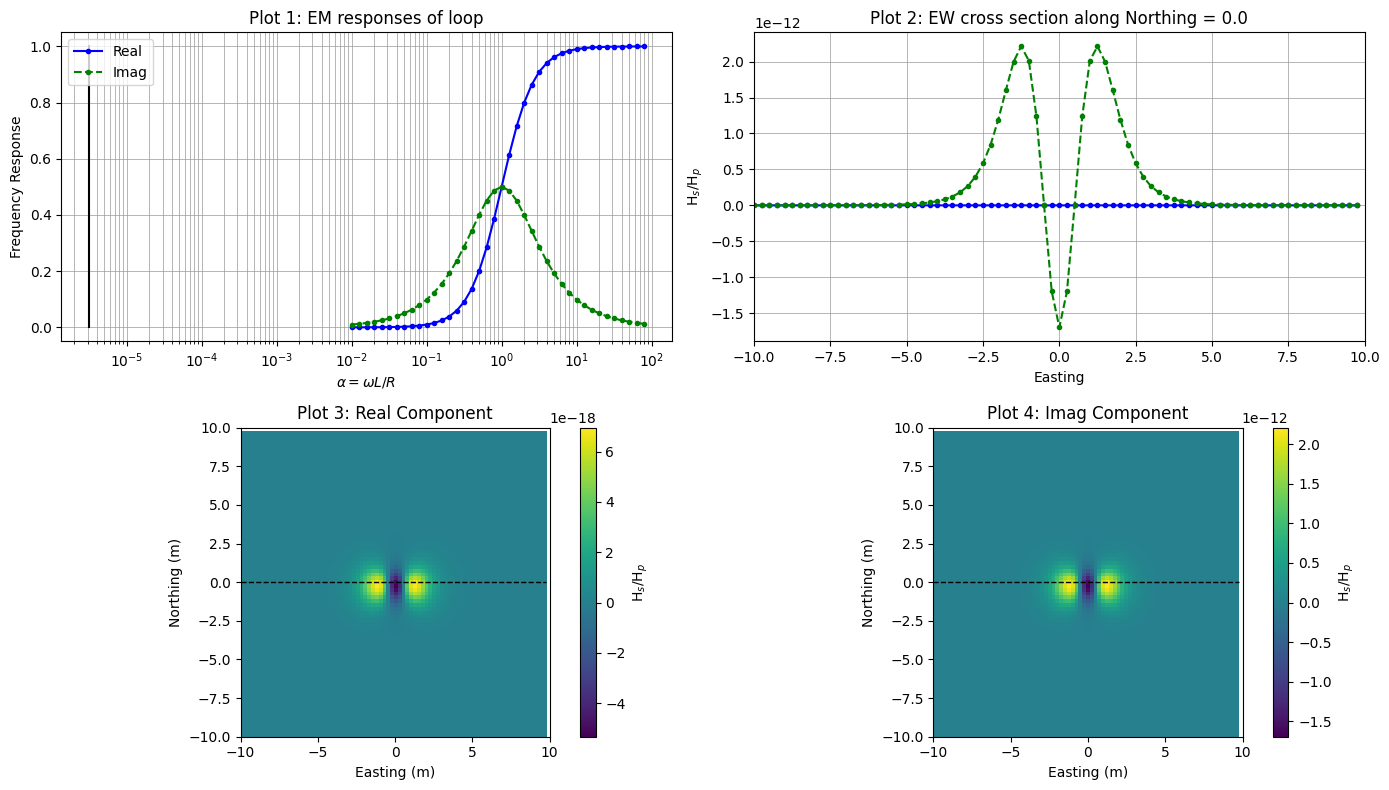

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from ipywidgets import interactive, IntSlider, widget, FloatText, FloatSlider, Checkbox


def mind(x, y, z, dincl, ddecl, x0, y0, z0, aincl, adecl):

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    z0 = np.array(z0, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    aincl = np.array(aincl, dtype=float)
    adecl = np.array(adecl, dtype=float)

    di = np.pi * dincl / 180.0
    dd = np.pi * ddecl / 180.0

    cx = np.cos(di) * np.cos(dd)
    cy = np.cos(di) * np.sin(dd)
    cz = np.sin(di)

    ai = np.pi * aincl / 180.0
    ad = np.pi * adecl / 180.0

    ax = np.cos(ai) * np.cos(ad)
    ay = np.cos(ai) * np.sin(ad)
    az = np.sin(ai)

    # begin the calculation
    a = x - x0
    b = y - y0
    h = z - z0

    rt = np.sqrt(a ** 2.0 + b ** 2.0 + h ** 2.0) ** 5.0

    txy = 3.0 * a * b / rt
    txz = 3.0 * a * h / rt
    tyz = 3.0 * b * h / rt

    txx = (2.0 * a ** 2.0 - b ** 2.0 - h ** 2.0) / rt
    tyy = (2.0 * b ** 2.0 - a ** 2.0 - h ** 2.0) / rt
    tzz = -(txx + tyy)

    bx = txx * cx + txy * cy + txz * cz
    by = txy * cx + tyy * cy + tyz * cz
    bz = txz * cx + tyz * cy + tzz * cz

    return bx * ax + by * ay + bz * az


def fem3loop(
    L, R, xc, yc, zc, dincl, ddecl, S, ht, f, xmin, xmax, dx, showDataPts=False
):

    L = np.array(L, dtype=float)
    R = np.array(R, dtype=float)
    xc = np.array(xc, dtype=float)
    yc = np.array(yc, dtype=float)
    zc = np.array(zc, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    S = np.array(S, dtype=float)
    ht = np.array(ht, dtype=float)
    f = np.array(f, dtype=float)
    dx = np.array(dx, dtype=float)

    ymin = xmin
    ymax = xmax
    dely = dx

    # generate the grid
    xp = np.arange(xmin, xmax, dx)
    yp = np.arange(ymin, ymax, dely)
    [y, x] = np.meshgrid(yp, xp)
    z = 0.0 * x - ht

    # set up the response arrays
    real_response = 0.0 * x
    imag_response = 0.0 * x

    # frequency characteristics
    alpha = 2.0 * np.pi * f * L / R

    f_factor = (alpha ** 2.0 + 1j * alpha) / (1 + alpha ** 2.0)

    # amin = 0.01
    # amax = 100.0
    da = 4.0 / 40.0
    alf = np.arange(-2.0, 2.0, da)
    alf = 10.0 ** alf

    fre = alf ** 2.0 / (1.0 + alf ** 2.0)
    fim = alf / (1.0 + alf ** 2.0)

    # simulate anomalies
    yt = y - S / 2.0
    yr = y + S / 2.0

    dm = -S / 2.0
    dp = S / 2.0

    M13 = mind(0.0, dm, 0.0, 90.0, 0.0, 0.0, dp, 0.0, 90.0, 0.0)
    M12 = L * mind(x, yt, z, 90.0, 0.0, xc, yc, zc, dincl, ddecl)
    M23 = L * mind(xc, yc, zc, dincl, ddecl, x, yr, z, 90.0, 0.0)

    c_response = -M12 * M23 * f_factor / (M13 * L)

    # scaled to simulate a net volumetric effect
    if np.logical_and(dincl == 0.0, ddecl == 0.0):
        real_response = np.real(c_response) * 0.0
        imag_response = np.imag(c_response) * 0.0
    else:
        real_response = np.real(c_response) * 1000.0
        imag_response = np.imag(c_response) * 1000.0

    fig, ax = plt.subplots(2, 2, figsize=(14, 8))

    ax[0][0].semilogx(alf, fre, ".-b")
    ax[0][0].semilogx(alf, fim, ".--g")
    ax[0][0].plot([alpha, alpha], [0.0, 1.0], "-k")
    ax[0][0].legend(["Real", "Imag"], loc=2)
    ax[0][0].set_xlabel("$\\alpha = \\omega L /R$")
    ax[0][0].set_ylabel("Frequency Response")
    ax[0][0].set_title("Plot 1: EM responses of loop")
    ax[0][0].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
    ax[0][0].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")

    kx = int(np.ceil(xp.size / 2.0))
    ax[0][1].plot(y[kx, :], real_response[kx, :], ".-b")  # kx
    ax[0][1].plot(y[kx, :], imag_response[kx, :], ".--g")
    # ax[0][1].legend(['Real','Imag'],loc=2)
    ax[0][1].set_xlabel("Easting")
    ax[0][1].set_ylabel("H$_s$/H$_p$")
    ax[0][1].set_title("Plot 2: EW cross section along Northing = %1.1f" % (x[kx, 0]))
    ax[0][1].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
    ax[0][1].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")
    ax[0][1].set_xlim(np.r_[xmin, xmax])

    vminR = real_response.min()
    vmaxR = real_response.max()
    ax[1][0].plot(np.r_[xp.min(), xp.max()], np.zeros(2), "k--", lw=1)
    clb = plt.colorbar(
        ax[1][0].imshow(
            real_response,
            extent=[xp.min(), xp.max(), yp.min(), yp.max()],
            vmin=vminR,
            vmax=vmaxR,
        ),
        ax=ax[1][0],
    )
    ax[1][0].set_xlim(np.r_[xmin, xmax])
    ax[1][0].set_ylim(np.r_[xmin, xmax])
    ax[1][0].set_xlabel("Easting (m)")
    ax[1][0].set_ylabel("Northing (m)")
    ax[1][0].set_title("Plot 3: Real Component")
    # ax[1][0].colorbar()
    clb.set_label("H$_s$/H$_p$")

    if showDataPts:
        XP, YP = np.meshgrid(xp, yp)
        ax[1][0].plot(XP, YP, ".", color=[0.2, 0.2, 0.2])

    vminI = imag_response.min()
    vmaxI = imag_response.max()
    ax[1][1].plot(np.r_[xp.min(), xp.max()], np.zeros(2), "k--", lw=1)
    clb = plt.colorbar(
        ax[1][1].imshow(
            imag_response,
            extent=[xp.min(), xp.max(), yp.min(), yp.max()],
            vmin=vminI,
            vmax=vmaxI,
        ),
        ax=ax[1][1],
    )
    ax[1][1].set_xlim(np.r_[xmin, xmax])
    ax[1][1].set_ylim(np.r_[xmin, xmax])
    ax[1][1].set_xlabel("Easting (m)")
    ax[1][1].set_ylabel("Northing (m)")
    ax[1][1].set_title("Plot 4: Imag Component")
    clb.set_label("H$_s$/H$_p$")

    if showDataPts:
        ax[1][1].plot(XP, YP, ".", color=[0.2, 0.2, 0.2])

    plt.tight_layout()
    plt.show()


def interactfem3loop():

    S = 4.0
    ht = 1.0
    xmin = -10.0
    xmax = 10.0
    zmax = 10.0
    # xmin = lambda dx: -40.*dx
    # xmax = lambda dx: 40.*dx

    def fem3loopwrap(L, R, yc, xc, zc, dincl, ddecl, f, dx, showDataPts):
        return fem3loop(
            L, R, -yc, xc, zc, dincl, ddecl, S, ht, f, xmin, xmax, dx, showDataPts
        )

    Q = interactive(
        fem3loopwrap,
        L=FloatSlider(
            min=0.00, max=0.20, step=0.01, value=0.10, continuous_update=False
        ),
        R=FloatSlider(
            min=0.0, max=20000.0, step=1000.0, value=2000.0, continuous_update=False
        ),
        xc=FloatSlider(
            min=-10.0, max=10.0, step=1.0, value=0.0, continuous_update=False
        ),
        yc=FloatSlider(
            min=-10.0, max=10.0, step=1.0, value=0.0, continuous_update=False
        ),
        zc=FloatSlider(min=0.0, max=zmax, step=0.5, value=1.0, continuous_update=False),
        dincl=FloatSlider(
            min=-90.0,
            max=90.0,
            step=1.0,
            value=0.0,
            continuous_update=False,
            description="I",
        ),
        ddecl=FloatSlider(
            min=0.0,
            max=180.0,
            step=1.0,
            value=90.0,
            continuous_update=False,
            description="D",
        ),
        f=FloatSlider(
            min=10.0, max=19990.0, step=10.0, value=10000.0, continuous_update=False
        ),
        dx=FloatSlider(
            min=0.25, max=5.0, step=0.25, value=0.25, continuous_update=False
        ),
        showDataPts=Checkbox(value=False),
    )

    return Q


if __name__ == "__main__":
    # L = 0.1
    # R = 2000
    R = 2000
    L = 1e-7
    xc = 0.0
    yc = 0.0
    zc = 2.0
    dincl = 0.0
    ddecl = 90.0
    S = 1.0
    ht = 0.05
    f = 10000.0
    xmin = -10.0
    xmax = 10.0
    dx = 0.25

    fem3loop(L, R, xc, yc, zc, dincl, ddecl, S, ht, f, xmin, xmax, dx)

[0.00624209 0.00748647 0.00897893 0.01076891 0.01291574 0.01549054
 0.01857864 0.02228237 0.02672444 0.03205207 0.03844177 0.04610529
 0.05529657 0.06632015 0.07954134 0.09539822 0.11441623 0.13722556
 0.16458201 0.19739209] 9.869604401089362e-07


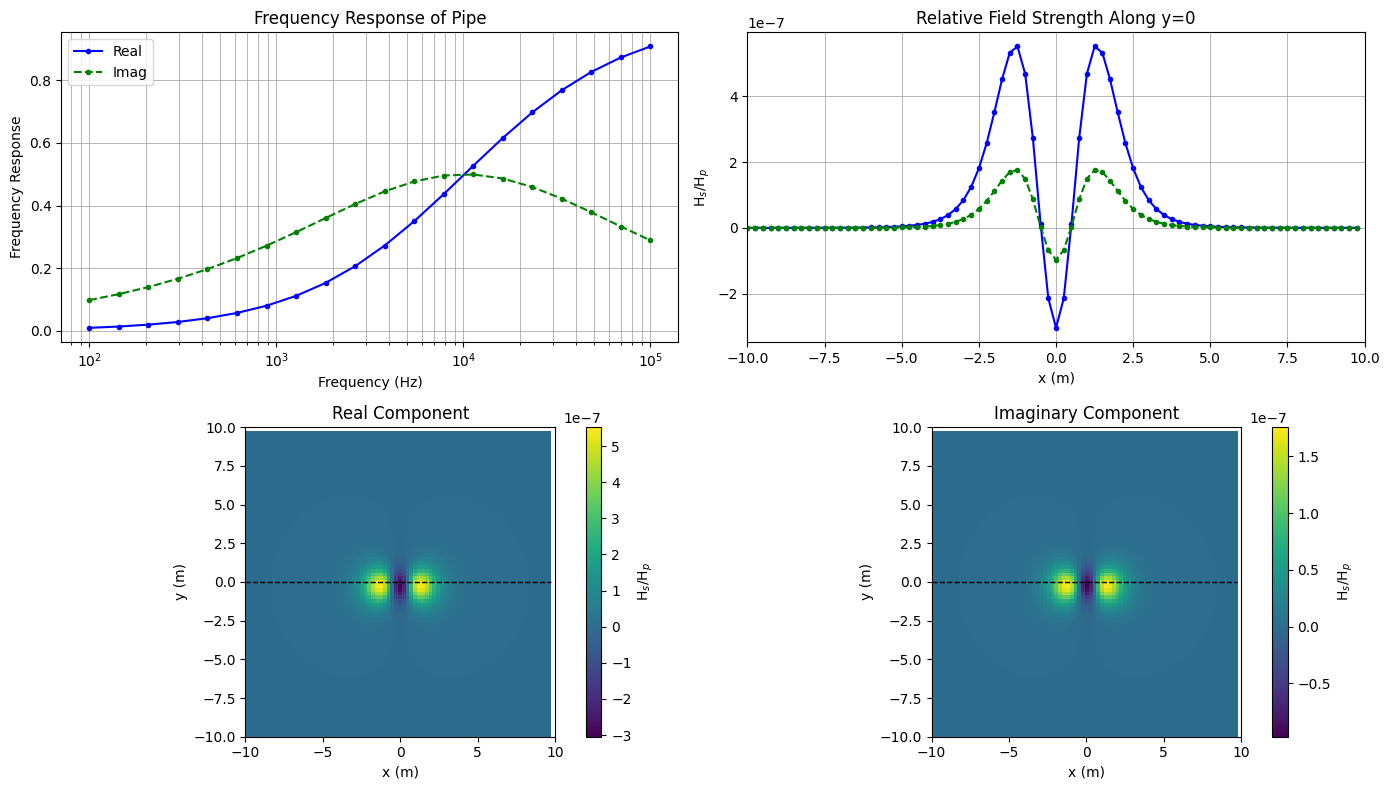

In [57]:
f = np.logspace(2,5,20)

response, f_factor = fem_pipe(
    sigma=1.0e4,
    mu=4*np.pi*10**(-7),
    xc=0.0,
    yc=0.0,
    zc=2.0,
    dincl=0.0,
    ddecl=90.0,
    dipole_dist=1.0,
    sensor_ht=0.05,
    f=f,
    xmin=-10.0,
    xmax=10.0,
    dx=0.25,
    N_loops=100,
    length=1,
    rad=0.05,
)

xp = np.arange(-10, 10, 0.25)
yp = np.arange(-10, 10, 0.25)
real_response = np.real(response[:, :, -1])
imag_response = np.imag(response[:, :, -1])

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

ax[0][0].semilogx(f, np.real(f_factor), ".-b")
ax[0][0].semilogx(f, np.imag(f_factor), ".--g")
# ax[0][0].plot([alpha, alpha], [0.0, 1.0], "-k")
ax[0][0].legend(["Real", "Imag"], loc=2)
ax[0][0].set_xlabel("Frequency (Hz)")
ax[0][0].set_ylabel("Frequency Response")
ax[0][0].set_title("Frequency Response of Pipe")
ax[0][0].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
ax[0][0].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")

kx = int(np.ceil(xp.size / 2.0))
ax[0][1].plot(yp[:], real_response[kx, :], ".-b")  # kx
ax[0][1].plot(yp[:], imag_response[kx, :], ".--g")
# ax[0][1].legend(['Real','Imag'],loc=2)
ax[0][1].set_xlabel("x (m)")
ax[0][1].set_ylabel("H$_s$/H$_p$")
ax[0][1].set_title("Relative Field Strength Along y=0")
ax[0][1].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
ax[0][1].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")
ax[0][1].set_xlim(np.r_[xmin, xmax])

vminR = real_response.min()
vmaxR = real_response.max()
ax[1][0].plot(np.r_[xp.min(), xp.max()], np.zeros(2), "k--", lw=1)
clb = plt.colorbar(
    ax[1][0].imshow(
        real_response,
        extent=[xp.min(), xp.max(), yp.min(), yp.max()],
        vmin=vminR,
        vmax=vmaxR,
    ),
    ax=ax[1][0],
)
ax[1][0].set_xlim(np.r_[xmin, xmax])
ax[1][0].set_ylim(np.r_[xmin, xmax])
ax[1][0].set_xlabel("x (m)")
ax[1][0].set_ylabel("y (m)")
ax[1][0].set_title("Real Component")
# ax[1][0].colorbar()
clb.set_label("H$_s$/H$_p$")

# if showDataPts:
#     XP, YP = np.meshgrid(xp, yp)
#     ax[1][0].plot(XP, YP, ".", color=[0.2, 0.2, 0.2])

vminI = imag_response.min()
vmaxI = imag_response.max()
ax[1][1].plot(np.r_[xp.min(), xp.max()], np.zeros(2), "k--", lw=1)
clb = plt.colorbar(
    ax[1][1].imshow(
        imag_response,
        extent=[xp.min(), xp.max(), yp.min(), yp.max()],
        vmin=vminI,
        vmax=vmaxI,
    ),
    ax=ax[1][1],
)
ax[1][1].set_xlim(np.r_[xmin, xmax])
ax[1][1].set_ylim(np.r_[xmin, xmax])
ax[1][1].set_xlabel("x (m)")
ax[1][1].set_ylabel("y (m)")
ax[1][1].set_title("Imaginary Component")
clb.set_label("H$_s$/H$_p$")

# if showDataPts:
#     ax[1][1].plot(XP, YP, ".", color=[0.2, 0.2, 0.2])

plt.tight_layout()
plt.show()
